## Prepare environment

After command above you should restart runtime

In [0]:
import tensorflow as tf
print(tf.__version__)
print(tf.test.is_gpu_available())
print(tf.test.is_built_with_cuda())

import matplotlib as mpl
print(mpl.__version__)

2.1.0
True
True
3.2.1


In [0]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
!gdown # <HIDDEN LINK>   download CK+ dataset
!gdown # <HIDDEN LINK>   download Jaffe
!unzip '*.zip'

Streaming output truncated to the last 5000 lines.
  inflating: CK+/cohn-kanade-images/S087/001/S087_001_00000011.png  
  inflating: CK+/cohn-kanade-images/S087/001/S087_001_00000005.png  
  inflating: CK+/cohn-kanade-images/S087/001/S087_001_00000007.png  
  inflating: CK+/cohn-kanade-images/S087/001/S087_001_00000006.png  
  inflating: CK+/cohn-kanade-images/S087/001/S087_001_00000002.png  
  inflating: CK+/cohn-kanade-images/S087/001/S087_001_00000003.png  
  inflating: CK+/cohn-kanade-images/S087/001/S087_001_00000001.png  
  inflating: CK+/cohn-kanade-images/S087/001/S087_001_00000008.png  
  inflating: CK+/cohn-kanade-images/S087/001/S087_001_00000009.png  
   creating: CK+/cohn-kanade-images/S087/006/
  inflating: CK+/cohn-kanade-images/S087/006/S087_006_00000004.png  
  inflating: CK+/cohn-kanade-images/S087/006/S087_006_00000010.png  
  inflating: CK+/cohn-kanade-images/S087/006/S087_006_00000011.png  
  inflating: CK+/cohn-kanade-images/S087/006/S087_006_00000005.png  
  infl

In [0]:
# Common
import numpy as np
# For data processing
from os import listdir
from random import sample
import cv2
from tqdm import tqdm
import glob
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # Setting Styles
import pandas as pd
# For model training
from random import uniform
import tensorflow.keras as keras
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, AvgPool2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, MaxPool1D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
# For model evaluation
from sklearn.metrics import confusion_matrix
import seaborn as sns
import collections

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Dataset processing

### Constants

In [0]:
DATA_DIR = '/content/CK+/'
FIGURES_DIR = '/content/figures/'
NUM_EMOTION_IMGS_PER_SEQ = 3
BATCH_SIZE = 64
EPOCHS = 100
DATA_AUGMENTATION = True
NUM_CLASSES = 8
RANDOM_STATE = 42
IMAGE_SIZE = (96, 96)

### Helper functions

In [0]:
def get_emotion_label(seq_path):
    with open(seq_path, 'r') as file:
        label = int(float(file.read().strip()))
    return label


def extract_face(img_grey):
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(img_grey, 1.1, 4)
    for (x, y, w, h) in faces:
        return img_grey[y:y + h, x:x + w]


def get_preprocessed_img(image_path):
    img_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_face = extract_face(img_gray)
    img_face = cv2.resize(img_face, IMAGE_SIZE)
    img_face = img_face.reshape((IMAGE_SIZE[0], IMAGE_SIZE[1], 1))
    return img_face

### Dataset extraction

In [0]:
path_to_ck_emotions = DATA_DIR + 'Emotion/'
path_to_ck_imgs = DATA_DIR + 'cohn-kanade-images/'
x, y = [], []
subjects = listdir(path_to_ck_emotions)
pbar = tqdm(total=len(subjects))
for subject in sample(subjects,len(subjects)):
    pbar.update(1)
    subject_path = path_to_ck_emotions + subject + '/'
    for seq in listdir(subject_path):
        seq_path = subject_path + seq + '/'
        emotion_files = listdir(seq_path)
        if emotion_files:
            label = get_emotion_label(seq_path + emotion_files[0])

            # # Skip "contept" expressions
            # if label==2:
            #   continue

            imgs_path = path_to_ck_imgs + subject + '/' + seq + '/'
            imgs = sorted(listdir(imgs_path))
            last_img_idx = len(imgs) - 1
            x.append(get_preprocessed_img(imgs_path + imgs[0]))
            y.append(0)
            for i in range(NUM_EMOTION_IMGS_PER_SEQ):
                factor = 1 if (last_img_idx < 10) else 1
                img_per_seq = imgs[last_img_idx - i * factor]
                x.append(get_preprocessed_img(imgs_path + img_per_seq))
                y.append(label)
pbar.close()
np.savez_compressed('cropped-faces-with_labels-dataset.npz',
                    np.asarray(x),
                    np.asarray(y))


100%|██████████| 123/123 [03:09<00:00,  1.54s/it]


Counter({0: 327, 7: 249, 5: 207, 3: 177, 1: 135, 6: 84, 4: 75, 2: 54})


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


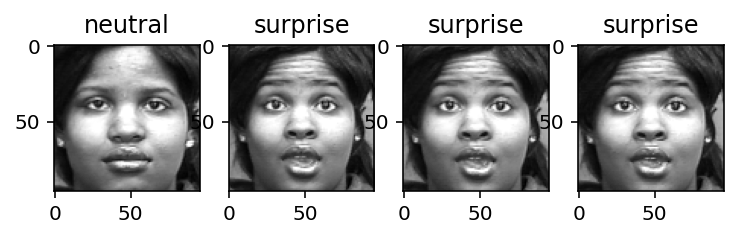

In [0]:
NUM_EMOTION_IMGS_PER_SEQ=3
def show_in_row(figure_idx, list_of_images, titles=None, disable_ticks=False):
    count = len(list_of_images)
    for idx in range(count):
        subplot = plt.subplot(1, count, idx + 1)
        if titles is not None:
            subplot.set_title(titles[idx])
        img = list_of_images[idx]
        img = img.reshape(IMAGE_SIZE)
        subplot.imshow(img, cmap='gray')
        if disable_ticks:
            plt.xticks([]), plt.yticks([])
    plt.savefig(FIGURES_DIR+'extracted_imgs_per_subject_'+str(figure_idx)+'.png')


# 0=neutral, 1=anger, 2=contempt, 3=disgust, 4=fear, 5=happy, 6=sadness, 7=surprise
emotion_titles = ['neutral', 'anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']
data = np.load('cropped-faces-with_labels-dataset.npz')
x, y = data['arr_0'], data['arr_1']
c = collections.Counter(y)
print(c)
for extracted_seq_id in range(4):
  first_idx = extracted_seq_id * (NUM_EMOTION_IMGS_PER_SEQ+1)
  last_idx = first_idx + (NUM_EMOTION_IMGS_PER_SEQ+1)
  show_in_row(extracted_seq_id, x[first_idx:last_idx], [emotion_titles[label] for label in y[first_idx:last_idx]])

## Model training

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2 (Batch (None, 96, 96, 1)         4         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 96, 96, 64)        1600      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 44, 44, 128)       204800    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 22, 22, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 18, 18, 256)       819200    
_________________________________________________________________
average_pooling2d_2 (Average (None, 2, 2, 256)        

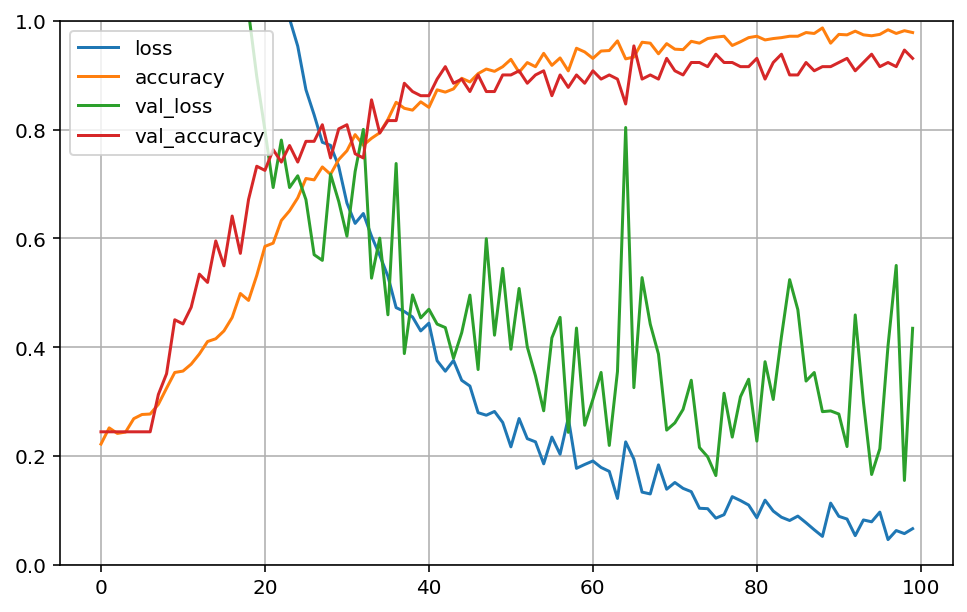

In [0]:
def plot_history(history):
  pd.DataFrame(history.history).plot(figsize=(8, 5))
  plt.grid(True)
  plt.gca().set_ylim(0, 1)  # set the vertical range to [0-1]
  plt.savefig(FIGURES_DIR+'training_history.png')


data = np.load('cropped-faces-with_labels-dataset.npz')
x, y = data['arr_0'], data['arr_1']

x = np.array(x) / 255.
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.1,
                                                    shuffle=False,
                                                    random_state=RANDOM_STATE)
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

model = Sequential()
model.add(BatchNormalization(input_shape=x_train.shape[1:]))
model.add(Conv2D(64,
                  (5, 5),
                  padding='same',
                  activation='relu',
                  use_bias=False))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128,
                  (5, 5),
                  activation='relu',
                  use_bias=False))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256,
                  (5, 5),
                  activation='relu',
                  use_bias=False))
model.add(AvgPool2D(pool_size=(9, 9),
                    strides=9))
model.add(Flatten())
model.add(Dense(300))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES,
                activation='softmax'))
model.summary()
plot_model(model=model, to_file=FIGURES_DIR+'cnn_model.png', show_layer_names=True, show_shapes=True)

opt = keras.optimizers.SGD(lr=.01, decay=1e-5, momentum=.9)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint("best_cnn_model.h5", save_best_only=True)

if not DATA_AUGMENTATION:
  print('Not using data augmentation.')
  model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            validation_data=(x_test, y_test),
            shuffle=True,
            callbacks=[checkpoint_cb])
else:
    print('Using real-time data augmentation.')
    datagen = ImageDataGenerator(rescale=1. / 255,
                                                rotation_range=15,
                                                width_shift_range=0.1,
                                                height_shift_range=0.1,
                                                shear_range=0.01,
                                                zoom_range=[0.9, 1.25],
                                                horizontal_flip=True,
                                                vertical_flip=False,
                                                fill_mode='reflect',
                                                data_format='channels_last',
                                                brightness_range=[0.5, 1.5])

    # Fit the model on the batches generated by datagen.flow().
    train_gen = datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)
    print(f'{x_train.shape} {y_train.shape} {len(train_gen)}')
    history = model.fit_generator(train_gen,
                                  epochs=EPOCHS,
                                  validation_data=(x_test, y_test),
                                  workers=4,
                                  callbacks=[checkpoint_cb])
scores = model.evaluate(x_test, y_test)
print(scores)
plot_history(history)
model.save("last_cnn_model.h5")






## Model evaluation

Accuracy on whole Jaffe dataset: 0.4976525902748108
Accuracy on subject independent test folder of CK+: 0.9465649127960205
Train folder of CK+ dataset: {'neutral': 295, 'anger': 129, 'contempt': 51, 'disgust': 153, 'fear': 60, 'happy': 186, 'sadness': 84, 'surprise': 219}
Whole Jaffe dataset: {'neutral': 30, 'anger': 30, 'disgust': 29, 'fear': 32, 'happy': 31, 'sadness': 31, 'surprise': 30}


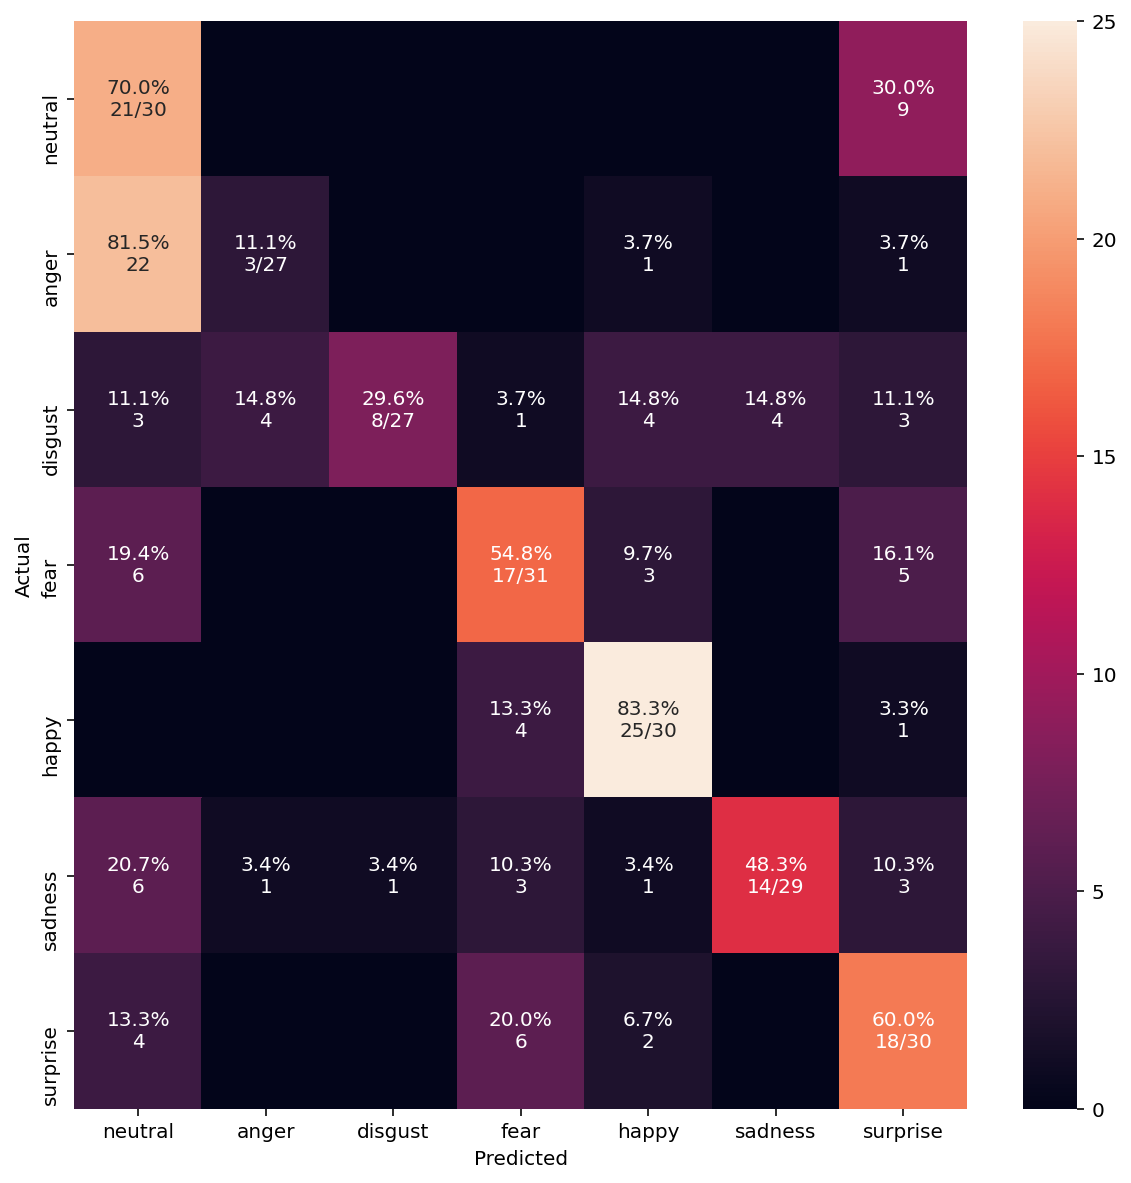

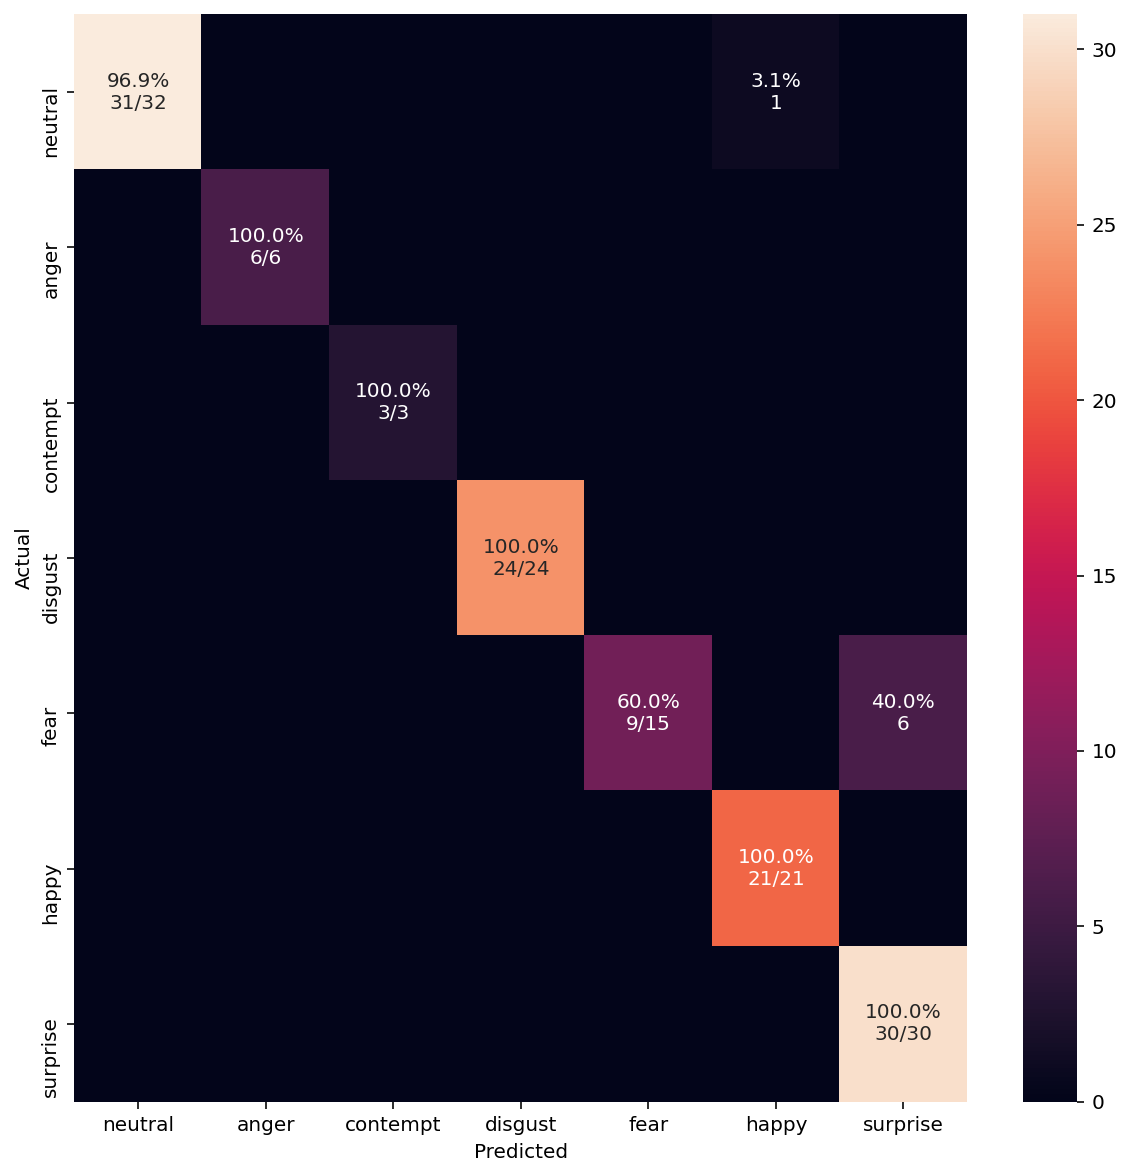

In [0]:
from collections import Counter
def cm_analysis(y_true, y_pred, labels, filename, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    plt.savefig(FIGURES_DIR+filename)


def extract_emotion(filename):
    slash_idx = filename.rfind('/', 0, len(filename) - 1)
    parts = filename[slash_idx:len(filename)].split('.', 4)
    if parts[1][:2] == 'HA':
        return 5
    if parts[1][:2] == 'SA':
        return 6
    if parts[1][:2] == 'SU':
        return 7
    if parts[1][:2] == 'AN':
        return 1
    if parts[1][:2] == 'DI':
        return 3
    if parts[1][:2] == 'FE':
        return 4
    if parts[1][:2] == 'NE':
        return 0

#emotion_titles = ['neutral', 'anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']
emotion_titles =[0,1,2,3,4,5,6,7]

filelist = glob.glob('/content/jaffe/*')

x_jaffe = []
y_jaffe = []
for file in filelist:
    if file[-4:] == 'tiff':
        x_jaffe.append(get_preprocessed_img(file))
        y_jaffe.append(extract_emotion(file))

model=load_model('best_cnn_model.h5')
x_jaffe = np.array(x_jaffe) / 255.
y_jaffe_cat = keras.utils.to_categorical(y_jaffe, NUM_CLASSES)
print(f'Accuracy on whole Jaffe dataset: {model.evaluate(x_jaffe,y_jaffe_cat,verbose=0)[1]}')
pred_index = model.predict_classes(x_jaffe)
emotion_titles = ['neutral', 'anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']
cm_analysis(y_jaffe, pred_index, set(y_jaffe),'jaffe_confusion_matrix.png',ymap=emotion_titles)
plt.savefig('df.png')

data = np.load('cropped-faces-with_labels-dataset.npz')
x_ck, y_ck = data['arr_0'], data['arr_1']



x_ck = np.array(x_ck) / 255.
x_ck_train, x_ck_test, y_ck_train, y_ck_test = train_test_split(x_ck, y_ck,test_size=0.1,shuffle=False,random_state=42)

y_ck_test_cat=keras.utils.to_categorical(y_ck_test, NUM_CLASSES)
pred_index = model.predict_classes(x_ck_test)
print(f'Accuracy on subject independent test folder of CK+: {model.evaluate(x_ck_test,y_ck_test_cat,verbose=0)[1]}')

c = Counter(y_ck_train)
ck_train_dict={emotion_titles[k]: v for k, v in sorted(dict(c).items())}
print(f'Train folder of CK+ dataset: {ck_train_dict}')

c = Counter(y_jaffe)
jaffe_dict={emotion_titles[k]: v for k, v in sorted(dict(c).items())}
print(f'Whole Jaffe dataset: {jaffe_dict}')

cm_analysis(y_ck_test, pred_index, set(y_ck_test),'ck_test_confusion_matrix',ymap=emotion_titles)